In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46547 instead
  warnings.warn(


In [3]:
print(client)

<Client: 'tcp://10.0.128.132:39863' processes=0 threads=0, memory=0 B>


In [4]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [5]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [6]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [7]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName


def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [8]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [9]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [10]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [11]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

hisOSSEFilePath5='/g/data/fu5/deg581/OSSE_SSHSST_XBT_PXLINES/output/'
modOSSEFilePath5='/g/data/fu5/deg581/OSSE_SSHSST_XBT_PXLINES/output/'
obsOSSEFilePath5='/g/data/fu5/deg581/OSSE_SSHSST_XBT_PXLINES/output/'

hisOSSEFilePath6='/g/data/fu5/deg581/OSSE_SSHSST_XBT_MONTHLY/output/'
modOSSEFilePath6='/g/data/fu5/deg581/OSSE_SSHSST_XBT_MONTHLY/output/'
obsOSSEFilePath6='/g/data/fu5/deg581/OSSE_SSHSST_XBT_MONTHLY/output/'

hisOSSEFilePath7='/g/data/fu5/deg581/OSSE_SSHSST_XBT_WEEKLY/output/'
modOSSEFilePath7='/g/data/fu5/deg581/OSSE_SSHSST_XBT_WEEKLY/output/'
obsOSSEFilePath7='/g/data/fu5/deg581/OSSE_SSHSST_XBT_WEEKLY/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [12]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))


In [13]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

In [14]:

# datelist = np.array(range(timeRange[0],timeRange[1],4))

# filelist=[hisOSSEFilePath1+prefixAnalysis+''+str(datelist[0])+'.nc']
# for dates in datelist[1:]:
#     filenameToAppend=hisOSSEFilePath1+prefixAnalysis+''+str(dates)+'.nc'
#     filelist.append(filenameToAppend)

# print(filelist)

In [15]:
# truth.close(), print('done')
# OSSE_SSHSST.close(), print('done')
# OSSE_SSHSST_XBT_N.close(), print('done')
# OSSE_SSHSST_XBT_S.close(), print('done')
# OSSE_SSHSST_XBT.close(), print('done')

In [16]:
# Load zeta data
VarToKeep = ['temp','z_rho0','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S','OSSE_SSHSST_XBT_PXLINES','OSSE_SSHSST_XBT_PXLINES_MONTHLY']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
# filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
# filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
# filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix
filelist_SSHSST_XBT_PXLINES=outputPath+outputPrefix+expNames[5]+outputSuffix
filelist_SSHSST_XBT_PXLINES_MONTHLY=outputPath+outputPrefix+expNames[6]+outputSuffix

truth = xr.open_dataset(filelistTruth)
# OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
# OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
# OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)
OSSE_SSHSST_XBT_PXLINES= xr.open_dataset(filelist_SSHSST_XBT_PXLINES)
OSSE_SSHSST_XBT_PXLINES_MONTHLY= xr.open_dataset(filelist_SSHSST_XBT_PXLINES_MONTHLY)

#load grid file

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False,
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    })
    return gridOut


grid = makeROMSGridObject(truth)

truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
# OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)
# OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
# OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_PXLINES,OSSE_SSHSST_XBT_PXLINES_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_PXLINES,VarToKeep)
OSSE_SSHSST_XBT_PXLINES_MONTHLY,OSSE_SSHSST_XBT_PXLINES_MONTHLY_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_PXLINES_MONTHLY,VarToKeep)


truth = truth.drop('z_rho')
# OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
# OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
# OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')
OSSE_SSHSST_XBT_PXLINES = OSSE_SSHSST_XBT_PXLINES.drop('z_rho')
OSSE_SSHSST_XBT_PXLINES_MONTHLY = OSSE_SSHSST_XBT_PXLINES_MONTHLY.drop('z_rho')

truth["z_rho0"] = truth.z_rho0.fillna(0)
# OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
# OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
# OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)
OSSE_SSHSST_XBT_PXLINES["z_rho0"] = OSSE_SSHSST_XBT_PXLINES.z_rho0.fillna(0)
OSSE_SSHSST_XBT_PXLINES_MONTHLY["z_rho0"] = OSSE_SSHSST_XBT_PXLINES_MONTHLY.z_rho0.fillna(0)


In [17]:

# def makeROMSGridObject(gridIn):
#     gridOut = Grid(gridIn, 
#     coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
#     'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
#     'Z':{'center':'s_rho', 'outer':'s_w'}},
#     periodic=False,
#     metrics = {
#         ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
#         ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
#         ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
#         ('X', 'Y'): ['dA'] # Areas
#     })
#     return gridOut


# grid = makeROMSGridObject(truth_bu)





In [18]:
# outline xbt array region

XBTboxlon = truth.lon_rho.isel(eta_rho=256,xi_rho=slice(74,271)).values
XBTboxdep0 = truth.z_rho0.isel(eta_rho=256,xi_rho=slice(74,271),s_rho=-1).values
XBTboxdep1 = truth.z_rho0.isel(eta_rho=256,xi_rho=slice(74,271),s_rho=0).values
XBTboxdep2 = -900
XBTboxdep1[XBTboxdep1<XBTboxdep2] = XBTboxdep2
boxLon=np.hstack([np.concatenate([XBTboxlon,np.flip(XBTboxlon,0)]),XBTboxlon[0]])
boxDep=np.hstack([np.concatenate([XBTboxdep0,np.flip(XBTboxdep1,0)]),XBTboxdep0[0]])

# fig,ax=plt.subplots(1)
# ax.plot(boxLon,boxDep)

In [19]:
time_range_to_load = slice('2012-01-01','2013-01-01')

truth = truth.sel(ocean_time=time_range_to_load)
# OSSE_SSHSST = OSSE_SSHSST.sel(ocean_time=time_range_to_load)
# OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load)
# OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load)
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load)
OSSE_SSHSST_XBT_PXLINES = OSSE_SSHSST_XBT_PXLINES.sel(ocean_time=time_range_to_load)
OSSE_SSHSST_XBT_PXLINES_MONTHLY = OSSE_SSHSST_XBT_PXLINES_MONTHLY.sel(ocean_time=time_range_to_load)

In [20]:
truth.load(), print('done')
# OSSE_SSHSST.load(), print('done')
# OSSE_SSHSST_XBT_N.load(), print('done')
# OSSE_SSHSST_XBT_S.load(), print('done')
OSSE_SSHSST_XBT.load(), print('done')
OSSE_SSHSST_XBT_PXLINES.load(), print('done')
OSSE_SSHSST_XBT_PXLINES_MONTHLY.load(), print('done')


done
done
done
done


(<xarray.Dataset>
 Dimensions:     (ocean_time: 74, s_rho: 30, eta_rho: 317, xi_rho: 272)
 Coordinates:
     z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.486 -1.038
   * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time  (ocean_time) datetime64[ns] 2012-01-01 2012-01-06 ... 2012-12-31
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.92
     dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
     dy          (eta_rho, xi_rho) float64 5e+03 4.999e+03 ... 4.881e+03
     dz          (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... 3.178
 Attributes: (12/39)
     file:              roms_fwd_outer1.nc
     format:            netCDF-3 64bit offset file
    

In [21]:
# define PXLINES times
from datetime import datetime

PXLINES_start = ['2012-01-30','2012-04-30','2012-07-30','2012-10-22','2013-01-21','2013-04-15','2013-07-22','2013-10-07']
PXLINES_end   = ['2012-02-02','2012-05-03','2012-08-02','2012-10-25','2013-01-24','2013-04-18','2013-07-25','2013-10-10']

# PXLINES_start = np.datetime64(datetime.fromisoformat(PXLINES_start))
# PXLINES_end = np.datetime64(datetime.fromisoformat(PXLINES_end))

PXLINES_start = np.array(PXLINES_start,dtype='datetime64')
PXLINES_end = np.array(PXLINES_end,dtype='datetime64')

In [22]:
PXLINES_start

array(['2012-01-30', '2012-04-30', '2012-07-30', '2012-10-22',
       '2013-01-21', '2013-04-15', '2013-07-22', '2013-10-07'],
      dtype='datetime64[D]')

In [23]:
Coast

<Figure size 432x288 with 0 Axes>

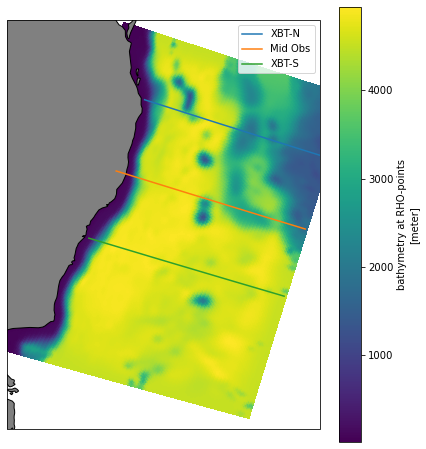

In [24]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[7,8])
ax = None

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([148, 161, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
truth_bu.h.plot(x='lon_rho',y='lat_rho', label='_nolegend_')
plt.plot(truth.lon_rho.isel(eta_rho=255,xi_rho=slice(74,271)),truth.lat_rho.isel(eta_rho=255,xi_rho=slice(74,271)),label='XBT-N')
plt.plot(truth.lon_rho.isel(eta_rho=185,xi_rho=slice(74,271)),truth.lat_rho.isel(eta_rho=185,xi_rho=slice(74,271)),label='Mid Obs')
plt.plot(truth.lon_rho.isel(eta_rho=119,xi_rho=slice(74,271)),truth.lat_rho.isel(eta_rho=119,xi_rho=slice(74,271)),label='XBT-S')
plt.legend()

In [25]:


etaTransect=255
RMSD_SSHSST_XBT_temp_255=(((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_PXLINES_temp_255=(((OSSE_SSHSST_XBT_PXLINES.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_255=(((OSSE_SSHSST_XBT_PXLINES_MONTHLY.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)

etaTransect=185
RMSD_SSHSST_XBT_temp_185=(((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_PXLINES_temp_185=(((OSSE_SSHSST_XBT_PXLINES.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_185=(((OSSE_SSHSST_XBT_PXLINES_MONTHLY.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)

etaTransect=119
RMSD_SSHSST_XBT_temp_119=(((OSSE_SSHSST_XBT.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_PXLINES_temp_119=(((OSSE_SSHSST_XBT_PXLINES.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_119=(((OSSE_SSHSST_XBT_PXLINES_MONTHLY.temp.isel(eta_rho=etaTransect) - truth.temp.isel(eta_rho=etaTransect))**2).mean(dim='ocean_time'))**(1/2)



In [26]:

etaTransect=255
x1 = truth.lon_rho.isel(eta_rho=etaTransect)
y1 = truth.z_rho0.isel(eta_rho=etaTransect)
x1,dump = xr.broadcast(x1,y1)
x1 = x1.transpose()
y1 = y1.transpose()

etaTransect=185
x2 = truth.lon_rho.isel(eta_rho=etaTransect)
y2 = truth.z_rho0.isel(eta_rho=etaTransect)
x2,dump = xr.broadcast(x2,y2)
x2 = x2.transpose()
y2 = y2.transpose()

etaTransect=119
x3 = truth.lon_rho.isel(eta_rho=etaTransect)
y3 = truth.z_rho0.isel(eta_rho=etaTransect)
x3,dump = xr.broadcast(x3,y3)
x3 = x3.transpose()
y3 = y3.transpose()


etaTransect=255
truth_temp_255=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
truth_temp_255.load(),print('done')
etaTransect=185
truth_temp_185=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
truth_temp_185.load(),print('done')
etaTransect=119
truth_temp_119=truth.temp.isel(eta_rho=etaTransect).mean(dim='ocean_time')
truth_temp_119.load(),print('done')





done
done
done


(<xarray.DataArray 'temp' (s_rho: 30, xi_rho: 272)>
 array([[        nan,         nan,         nan, ...,  0.91835295,
          0.90143737,  0.8696867 ],
        [        nan,         nan,         nan, ...,  0.92652337,
          0.91623445,  0.89959535],
        [        nan,         nan,         nan, ...,  0.98603396,
          0.9891573 ,  0.99616747],
        ...,
        [        nan,         nan,         nan, ..., 18.61648637,
         18.61830937, 18.62492244],
        [        nan,         nan,         nan, ..., 18.62729054,
         18.62703913, 18.63175905],
        [        nan,         nan,         nan, ..., 18.64710628,
         18.64272201, 18.64446769]])
 Coordinates:
     z_rho0   (xi_rho, s_rho) float64 0.0 0.0 0.0 0.0 ... -10.47 -5.663 -1.593
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho  (xi_rho) float64 149.4 149.4 149.4 149.5 ... 159.5 159.5 159.6
     lat_rho  (xi_rho) float64 -33.46 -33.47 -33.48 ... -36.47 -36.49 -36.51

In [42]:
truth["dV0"] = (truth.dx*truth.dy*truth.dz).mean(dim='ocean_time')

weights = truth.dV0
weights.name = "weights"

zLims = -2000 # above 2000m
mask = (np.ones((truth.dims['eta_rho'],truth.dims['xi_rho'],truth.dims['s_rho']))*(truth.z_rho0*0+1)).where((truth.z_rho0>zLims))
zLims = -1000 # above 2000m
mask1000 = (np.ones((truth.dims['eta_rho'],truth.dims['xi_rho'],truth.dims['s_rho']))*(truth.z_rho0*0+1)).where((truth.z_rho0>zLims))


Text(0.99, 0.15, '$\\overline{\\mathrm{RMS}}_{1000m}$ = 1.59$^\\circ$C')

<Figure size 432x288 with 0 Axes>

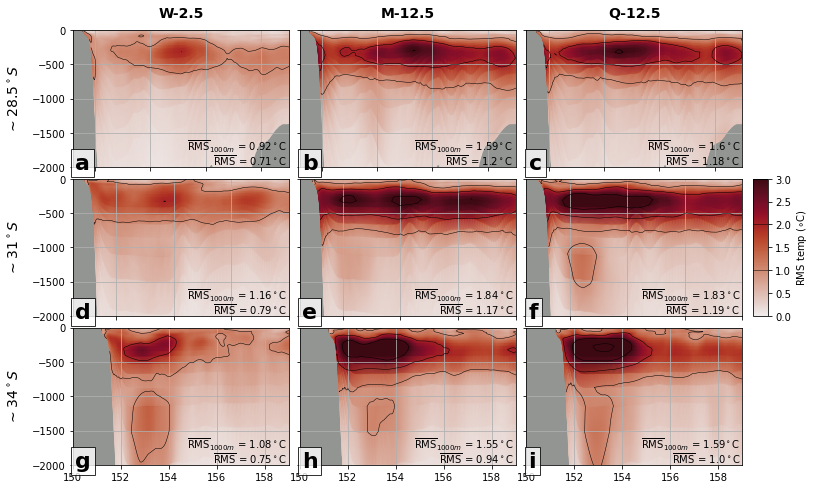

In [61]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.56, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    cax.set_ylabel('temp ($\circ C$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cbar,im




gs = gridspec.GridSpec(nrows=3,ncols=3,wspace=0.05, hspace=0.085)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12,8])
ax = None


#row 5
ax = addSubplot_VerticalTransect(x1,y1,RMSD_SSHSST_XBT_temp_255,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x1,y1,RMSD_SSHSST_XBT_temp_255,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(-.27, .5, '$\sim28.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(0.5, 1.12, 'W-2.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])
ax[0].set_xticklabels([])
RMSval = RMSD_SSHSST_XBT_temp_255.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_temp_255.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(x2,y2,RMSD_SSHSST_XBT_temp_185,gs,1,0,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x2,y2,RMSD_SSHSST_XBT_temp_185,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(-.27, .5,  '$\sim31^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_xticklabels([])
ax[0].set_xlim([152.5,160])
RMSval = RMSD_SSHSST_XBT_temp_185.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_temp_185.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax  = addSubplot_VerticalTransect(x3,y3,RMSD_SSHSST_XBT_temp_119,gs,2,0,'g',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x3,y3,RMSD_SSHSST_XBT_temp_119,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(-.27, .5,  '$\sim34^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_yticklabels([])
ax[0].set_xlim([150,159])
RMSval = RMSD_SSHSST_XBT_temp_119.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_temp_119.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)


ax = addSubplot_VerticalTransect(x1,y1,RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_255,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x1,y1,RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_255,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(0.5, 1.12, 'M-12.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
RMSval = RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_255.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_255.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(x2,y2,RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_185,gs,1,1,'e',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x2,y2,RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_185,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5,  '$\sim32^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
RMSval = RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_185.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_185.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax  = addSubplot_VerticalTransect(x3,y3,RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_119,gs,2,1,'h',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x3,y3,RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_119,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
# ax[0].text(-.27, .5,  '$\sim35.5^\circ S$',fontsize=14, fontweight='bold', rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_yticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([150,159])
RMSval = RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_119.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_PXLINES_MONTHLY_temp_119.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)



#col6
ax = addSubplot_VerticalTransect(x1,y1,RMSD_SSHSST_XBT_PXLINES_temp_255,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x1,y1,RMSD_SSHSST_XBT_PXLINES_temp_255,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
ax[0].text(0.5, 1.12, 'Q-12.5',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
RMSval = RMSD_SSHSST_XBT_PXLINES_temp_255.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_PXLINES_temp_255.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(x2,y2,RMSD_SSHSST_XBT_PXLINES_temp_185,gs,1,2,'f',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x2,y2,RMSD_SSHSST_XBT_PXLINES_temp_185,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlim([152.5,160])
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[1], cax=cax)
cbar.ax.set_ylabel('RMS temp ($\circ$C)')
cbar.add_lines(co)
RMSval = RMSD_SSHSST_XBT_PXLINES_temp_185.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_PXLINES_temp_185.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax  = addSubplot_VerticalTransect(x3,y3,RMSD_SSHSST_XBT_PXLINES_temp_119,gs,2,2,'i',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ax[0].contour(x3,y3,RMSD_SSHSST_XBT_PXLINES_temp_119,levels=np.arange(0,5,1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([150,159])
RMSval = RMSD_SSHSST_XBT_PXLINES_temp_119.where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.99, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)
RMSval = RMSD_SSHSST_XBT_PXLINES_temp_119.where(mask1000==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(0.99, .15, '$\overline{\mathrm{RMS}}_{1000m}$ = '+str(np.round(RMSval.values,2))+'$^\circ$C',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)



(-1000.0, 0.0)

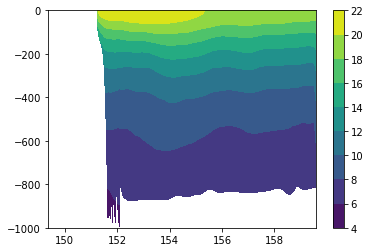

In [28]:
# this is what the top 1000m looks like
plt.contourf(x3,y3,(OSSE_SSHSST_XBT_PXLINES.temp.where(OSSE_SSHSST_XBT_PXLINES.isel(eta_rho=etaTransect).z_rho0>-1000).where(OSSE_SSHSST_XBT_PXLINES.eta_rho==etaTransect)).isel(eta_rho=etaTransect).mean(dim='ocean_time'))
plt.colorbar()
plt.ylim(-1000,0)

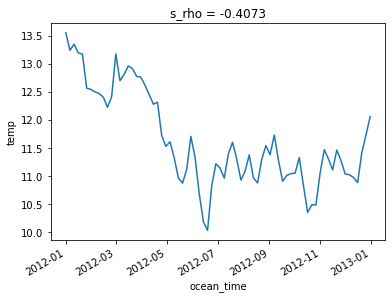

In [29]:
#just checking for seasonal cycle
OSSE_SSHSST_XBT_PXLINES.temp.isel(eta_rho=etaTransect,s_rho=12).mean(dim='xi_rho').plot()



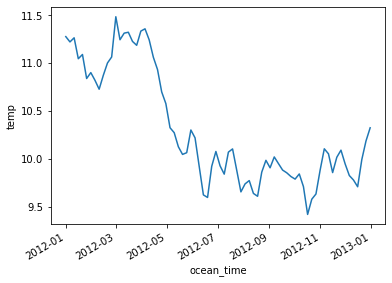

In [30]:
#this is how i make a grid average
grid.average(OSSE_SSHSST_XBT_PXLINES.temp.where(OSSE_SSHSST_XBT_PXLINES.isel(eta_rho=etaTransect).z_rho0>-1000).where(OSSE_SSHSST_XBT_PXLINES.eta_rho==etaTransect),['X','Z','Y']).plot()

In [63]:
# make square differences
# diff2_SSHSST = (OSSE_SSHSST.temp - truth.temp)**2
# diff2_SSHSST_XBT_N = (OSSE_SSHSST_XBT_N.temp - truth.temp)**2
# diff2_SSHSST_XBT_S = (OSSE_SSHSST_XBT_S.temp - truth.temp)**2
diff2_SSHSST_XBT = (OSSE_SSHSST_XBT.temp - truth.temp)**2
diff2_SSHSST_XBT_PXLINES = (OSSE_SSHSST_XBT_PXLINES.temp - truth.temp)**2
diff2_SSHSST_XBT_PXLINES_MONTHLY = (OSSE_SSHSST_XBT_PXLINES_MONTHLY.temp - truth.temp)**2

# take spatial mean and square root to form RMSD

etaTransect=255
RMSD_time_SSHSST_XBT_NthXBTObs=(grid.average(diff2_SSHSST_XBT.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_NthXBTObs=(grid.average(diff2_SSHSST_XBT_PXLINES.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_NthXBTObs=(grid.average(diff2_SSHSST_XBT_PXLINES_MONTHLY.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5

RMSD_time_SSHSST_XBT_NthXBTObs_500=(grid.average(diff2_SSHSST_XBT.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_NthXBTObs_500=(grid.average(diff2_SSHSST_XBT_PXLINES.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_NthXBTObs_500=(grid.average(diff2_SSHSST_XBT_PXLINES_MONTHLY.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5


etaTransect=185
RMSD_time_SSHSST_XBT_MidObs=(grid.average(diff2_SSHSST_XBT.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MidObs=(grid.average(diff2_SSHSST_XBT_PXLINES.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_MidObs=(grid.average(diff2_SSHSST_XBT_PXLINES_MONTHLY.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5

RMSD_time_SSHSST_XBT_MidObs_500=(grid.average(diff2_SSHSST_XBT.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MidObs_500=(grid.average(diff2_SSHSST_XBT_PXLINES.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_MidObs_500=(grid.average(diff2_SSHSST_XBT_PXLINES_MONTHLY.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5


etaTransect=119
RMSD_time_SSHSST_XBT_SthXBTObs=(grid.average(diff2_SSHSST_XBT.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_SthXBTObs=(grid.average(diff2_SSHSST_XBT_PXLINES.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_SthXBTObs=(grid.average(diff2_SSHSST_XBT_PXLINES_MONTHLY.where(truth.isel(eta_rho=etaTransect).z_rho0>-1000).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5

RMSD_time_SSHSST_XBT_SthXBTObs_500=(grid.average(diff2_SSHSST_XBT.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_SthXBTObs_500=(grid.average(diff2_SSHSST_XBT_PXLINES.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_SthXBTObs_500=(grid.average(diff2_SSHSST_XBT_PXLINES_MONTHLY.where(truth.isel(eta_rho=etaTransect).z_rho0>-500).where(truth.eta_rho==etaTransect),['X','Z','Y']))**0.5



In [32]:
print('locations where each transect reaches the coastline')
transectEta=255
print('XBT-N')
print(OSSE_SSHSST_XBT_bu.lon_rho.isel(eta_rho=transectEta).where(OSSE_SSHSST_XBT_bu.mask_rho.isel(eta_rho=transectEta)==1, drop=True).squeeze().isel(xi_rho=0).values.round(2))
print(OSSE_SSHSST_XBT_bu.lat_rho.isel(eta_rho=transectEta).where(OSSE_SSHSST_XBT_bu.mask_rho.isel(eta_rho=transectEta)==1, drop=True).squeeze().isel(xi_rho=0).values.round(2))

transectEta=185
print('Mid Obs')
print(OSSE_SSHSST_XBT_bu.lon_rho.isel(eta_rho=transectEta).where(OSSE_SSHSST_XBT_bu.mask_rho.isel(eta_rho=transectEta)==1, drop=True).squeeze().isel(xi_rho=0).values.round(2))
print(OSSE_SSHSST_XBT_bu.lat_rho.isel(eta_rho=transectEta).where(OSSE_SSHSST_XBT_bu.mask_rho.isel(eta_rho=transectEta)==1, drop=True).squeeze().isel(xi_rho=0).values.round(2))


transectEta=119
print('XBT-S')
print(OSSE_SSHSST_XBT_bu.lon_rho.isel(eta_rho=transectEta).where(OSSE_SSHSST_XBT_bu.mask_rho.isel(eta_rho=transectEta)==1, drop=True).squeeze().isel(xi_rho=0).values.round(2))
print(OSSE_SSHSST_XBT_bu.lat_rho.isel(eta_rho=transectEta).where(OSSE_SSHSST_XBT_bu.mask_rho.isel(eta_rho=transectEta)==1, drop=True).squeeze().isel(xi_rho=0).values.round(2))




locations where each transect reaches the coastline
XBT-N
153.59
-28.28
Mid Obs
152.93
-31.4
XBT-S
151.24
-34.03


(15335.0, 15710.0)

<Figure size 432x288 with 0 Axes>

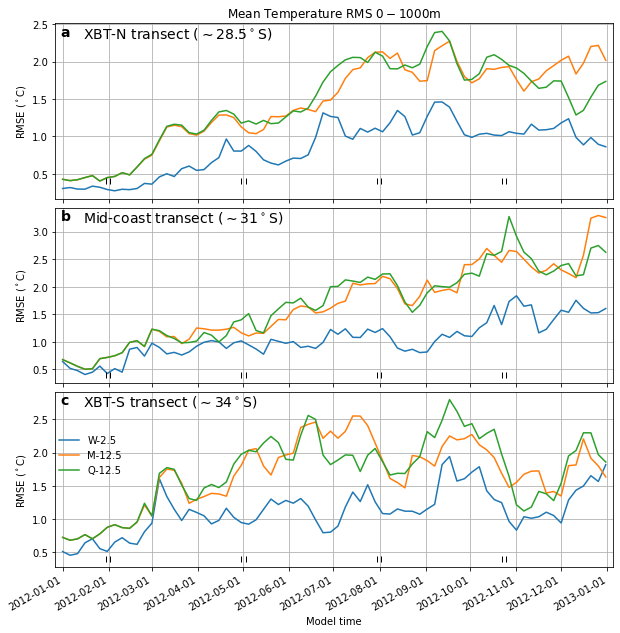

In [96]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
# RMSD_time_SSHSST_Woll.plot(label='Surf')
# RMSD_time_SSHSST_XBT_N_Woll.plot(label='XBT-N')
# RMSD_time_SSHSST_XBT_S_Woll.plot(label='XBT-S')
RMSD_time_SSHSST_XBT_NthXBTObs.plot(label='XBT-W')
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_NthXBTObs.plot(label='M-12.5')
RMSD_time_SSHSST_XBT_PXLINES_NthXBTObs.plot(label='XBT-Q')
# ax.legend()
ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('RMSE ($^\circ$C)')
ax.set_title('Mean Temperature RMS $0-1000$m')
ax.text(0.01,0.99,'a', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.05,0.99,'XBT-N transect ($\sim28.5^\circ$S)', transform=ax.transAxes,fontsize=14, va='top',ha='left')
test=ax.get_xlim()
ax.plot(PXLINES_start,0.4*np.ones(np.shape(PXLINES_start)),marker='|',linestyle='None',color='k')
ax.plot(PXLINES_end,0.4*np.ones(np.shape(PXLINES_end)),marker='|',linestyle='None',color='k')
ax.set_xticks(15340+np.cumsum(np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])))
ax.set_xlim(15335,15710)

ax = fig.add_subplot(gs[1,0])
# RMSD_time_SSHSST_SthXBTObs.plot(label='Surf')
# RMSD_time_SSHSST_XBT_N_SthXBTObs.plot(label='XBT-N')
# RMSD_time_SSHSST_XBT_S_SthXBTObs.plot(label='XBT-S')
RMSD_time_SSHSST_XBT_MidObs.plot(label='XBT-W')
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_MidObs.plot(label='M-12.5')
RMSD_time_SSHSST_XBT_PXLINES_MidObs.plot(label='XBT-Q')
# ax.legend()
ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('RMSE ($^\circ$C)')
# ax.set_title('Mid-coast transect ($\sim31^\circ$S) temperature RMSE >1000m')
ax.text(0.01,0.99,'b', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.05,0.99,'Mid-coast transect ($\sim31^\circ$S)', transform=ax.transAxes,fontsize=14, va='top',ha='left')
ax.plot(PXLINES_start,0.4*np.ones(np.shape(PXLINES_start)),marker='|',linestyle='None',color='k')
ax.plot(PXLINES_end,0.4*np.ones(np.shape(PXLINES_end)),marker='|',linestyle='None',color='k')
ax.set_xlim(15335,15710)
ax.set_xticks(15340+np.cumsum(np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])))

ax = fig.add_subplot(gs[2,0])
# RMSD_time_SSHSST_3.plot(label='Surf')
# RMSD_time_SSHSST_XBT_N_3.plot(label='XBT-N')
# RMSD_time_SSHSST_XBT_S_3.plot(label='XBT-S')
RMSD_time_SSHSST_XBT_SthXBTObs.plot(label='W-2.5')
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_SthXBTObs.plot(label='M-12.5')
RMSD_time_SSHSST_XBT_PXLINES_SthXBTObs.plot(label='Q-12.5')
ax.legend(loc=[0.0,0.5],frameon=False)
ax.grid()
ax.set_ylabel('RMSE ($^\circ$C)')
# ax.set_title('XBT-S transect ($\sim34^\circ$S) temperature RMSE 0-1000m')
ax.text(0.01,0.99,'c', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.05,0.99,'XBT-S transect ($\sim34^\circ$S)', transform=ax.transAxes,fontsize=14, va='top',ha='left')
ax.plot(PXLINES_start,0.4*np.ones(np.shape(PXLINES_start)),marker='|',linestyle='None',color='k')
ax.plot(PXLINES_end,0.4*np.ones(np.shape(PXLINES_end)),marker='|',linestyle='None',color='k')
ax.set_xlabel('Model time')
ax.set_xticks(15340+np.cumsum(np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])))
ax.set_xlim(15335,15710)


In [100]:
len(np.arange(8037, 8401,4))

91

In [75]:
15340+np.cumsum(np.array([0,31,29,31,30,31,30,31,31,30,31,30,31]))

array([15340, 15371, 15400, 15431, 15461, 15492, 15522, 15553, 15584,
       15614, 15645, 15675, 15706])

In [74]:
np.arange(0,100,20)

array([ 0, 20, 40, 60, 80])

<Figure size 432x288 with 0 Axes>

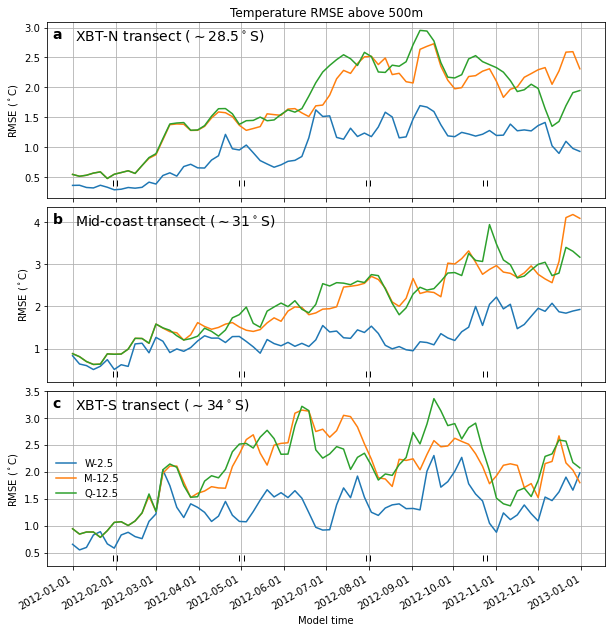

In [79]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0])
# RMSD_time_SSHSST_Woll.plot(label='Surf')
# RMSD_time_SSHSST_XBT_N_Woll.plot(label='XBT-N')
# RMSD_time_SSHSST_XBT_S_Woll.plot(label='XBT-S')
RMSD_time_SSHSST_XBT_NthXBTObs_500.plot(label='W-2.5')
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_NthXBTObs_500.plot(label='M-12.5')
RMSD_time_SSHSST_XBT_PXLINES_NthXBTObs_500.plot(label='Q-12.5')

# ax.legend()
ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('RMSE ($^\circ$C)')
ax.set_title('Temperature RMSE above 500m')
ax.text(0.01, 0.97, 'a', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.05, 0.97, 'XBT-N transect ($\sim28.5^\circ$S)', transform=ax.transAxes,fontsize=14, va='top')
test=ax.get_xlim()
ax.plot(PXLINES_start,0.4*np.ones(np.shape(PXLINES_start)),marker='|',linestyle='None',color='k')
ax.plot(PXLINES_end,0.4*np.ones(np.shape(PXLINES_end)),marker='|',linestyle='None',color='k')
ax.set_xlim(test)
ax.set_xticks(15340+np.cumsum(np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])))

ax = fig.add_subplot(gs[1,0])
# RMSD_time_SSHSST_SthXBTObs.plot(label='Surf')
# RMSD_time_SSHSST_XBT_N_SthXBTObs.plot(label='XBT-N')
# RMSD_time_SSHSST_XBT_S_SthXBTObs.plot(label='XBT-S')
RMSD_time_SSHSST_XBT_MidObs_500.plot(label='W-2.5')
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_MidObs_500.plot(label='M-12.5')
RMSD_time_SSHSST_XBT_PXLINES_MidObs_500.plot(label='Q-12.5')

# ax.legend()
ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('RMSE ($^\circ$C)')
ax.text(0.01, 0.97, 'b', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.05, 0.97, 'Mid-coast transect ($\sim31^\circ$S)', transform=ax.transAxes,fontsize=14, va='top')
test=ax.get_xlim()
ax.plot(PXLINES_start,0.4*np.ones(np.shape(PXLINES_start)),marker='|',linestyle='None',color='k')
ax.plot(PXLINES_end,0.4*np.ones(np.shape(PXLINES_end)),marker='|',linestyle='None',color='k')
ax.set_xlim(test)
ax.set_xticks(15340+np.cumsum(np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])))

ax = fig.add_subplot(gs[2,0])
# RMSD_time_SSHSST_3.plot(label='Surf')
# RMSD_time_SSHSST_XBT_N_3.plot(label='XBT-N')
# RMSD_time_SSHSST_XBT_S_3.plot(label='XBT-S')
RMSD_time_SSHSST_XBT_SthXBTObs_500.plot(label='W-2.5')
RMSD_time_SSHSST_XBT_PXLINES_MONTHLY_SthXBTObs_500.plot(label='M-12.5')
RMSD_time_SSHSST_XBT_PXLINES_SthXBTObs_500.plot(label='Q-12.5')

ax.legend(frameon=False,loc='center left')
ax.grid()
ax.set_ylabel('RMSE ($^\circ$C)')
ax.text(0.01, 0.97, 'c', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.05, 0.97, 'XBT-S transect ($\sim34^\circ$S)', transform=ax.transAxes,fontsize=14, va='top')
test=ax.get_xlim()
ax.plot(PXLINES_start,0.4*np.ones(np.shape(PXLINES_start)),marker='|',linestyle='None',color='k')
ax.plot(PXLINES_end,0.4*np.ones(np.shape(PXLINES_end)),marker='|',linestyle='None',color='k')
ax.set_xlim(test)
ax.set_xlabel('Model time')
ax.set_xticks(15340+np.cumsum(np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])))